## The  Ultimate 2000s Playlist


### What do we want to do?

We want to analyze the attributes of the top 50 songs of the 2000s, to make an ultimate playlists that captures the feeling of the 2000s.


 First, the necessary imports!

In [141]:
import numpy as np
from datascience import * 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

import main
from songs import Song_Attributes
from dotenv import load_dotenv
import os
import base64
from requests import post, get
import json
from songs import Song_Attributes
import requests

### Function for plotting attributes
Plots the average attributes of a playlist, puts them on a scale of 0-100% of the possible value range.

In [155]:
def plotting(playlist_final):

    danceabilityAry = make_array()
    loudnessAry = make_array()
    valenceAry = make_array()
    energyAry = make_array()
    speechinessAry = make_array()

    for song in playlist_final:
        danceabilityAry = np.append(danceabilityAry, song.danceability)
        loudnessAry = np.append(loudnessAry, song.loudness)
        valenceAry = np.append(valenceAry, song.valence)
        energyAry = np.append(energyAry, song.energy)
        speechinessAry = np.append(speechinessAry, song.speechiness)



    playlistTable = Table().with_columns('Danceability', danceabilityAry, 'Loudness', loudnessAry, 'Valence', valenceAry,
                                     'Energy', energyAry, 'Speechiness', speechinessAry)

    # normalize ranges
    danceabilityAry = danceabilityAry * 100
    loudnessAry = (((loudnessAry + 60) * 100) / 60)
    valenceAry = valenceAry * 100
    energyAry = energyAry * 100
    speechinessAry = speechinessAry * 100
    
    attributesAry = make_array('Danceability', 'Loudness', 'Valence', 'Energy', 'Speechiness')

    danceAvg = np.mean(danceabilityAry)
    loudAvg = np.mean(loudnessAry)
    valenceAvg = np.mean(valenceAry)
    energyAvg = np.mean(energyAry)
    speechAvg = np.mean(speechinessAry)

    averageAry = make_array(danceAvg, loudAvg, valenceAvg, energyAvg, speechAvg)

    averageTable = Table().with_columns('Attribute', attributesAry, 'Average', averageAry)

    averageTable.barh('Attribute', 'Average')



### Helper Functions
These functions allow us to find songs, make a playlist based on attribute value ranges, and store the artists and song names of each song.

In [156]:
load_dotenv()




client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")




def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")




    url = "https://accounts.spotify.com/api/token"
    headers = {
    "Authorization": "Basic " + auth_base64,
    "Content-Type": "application/x-www-form-urlencoded"
    }
    data ={"grant_type": "client_credentials"}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token




def get_auth_header(token):
    return{"Authorization": "Bearer " + token}


def search_for_songs(token, start_year, end_year, offset):

    url = "https://api.spotify.com/v1/search"
    start_year_str = str(start_year)
    end_year_str = str(end_year)
    headers = get_auth_header(token)
    query = f"?q=year:{start_year_str}-{end_year_str}&type=track&limit=50&offset={offset}"

    query_url = url + query
    result = get(query_url, headers=headers)
    json_result = json.loads(result.content)["tracks"]
    return json_result


def search_attributes(token, song_ids):
    url = "https://api.spotify.com/v1/audio-features"
    headers = get_auth_header(token)
    query = f"?{song_ids}&limit=50"
    query_url = url + query
    result = get(query_url, headers=headers)
    json_result = json.loads(result.content)
    return json_result


def make_playlist(size, start_year:int, end_year:int, dance_min: float, dance_max: float, loudness_min: float, loudness_max:float, valence_min: float, valence_max: float, energy_min:float, energy_max: float, speechiness_min: float, speechiness_max: float):

    playlist: list[Song_Attributes] = []
    offset_idx = 0

    while (len(playlist) < size):
        token = get_token()
        result = search_for_songs(token, start_year, end_year, offset_idx * 50)
        song_ids = []
        for song in result["items"]: song_ids.append(song['id'])
        song_id_str = "ids="
        for id in song_ids: song_id_str += f"{id},"
        song_attributes = search_attributes(token, song_id_str)
        # print(song_attributes)

        song_atts = {}

        for song_id, attribute in zip(song_ids, song_attributes["audio_features"]):
            if song_id not in song_atts:
                song_atts[song_id] = Song_Attributes(attribute, song_id)

        for key in song_atts:
            if dance_min <= song_atts[key].danceability <= dance_max and loudness_min <= song_atts[key].loudness <= loudness_max and valence_min <= song_atts[key].valence <= valence_max and energy_min <= song_atts[key].energy <= energy_max and speechiness_min <= song_atts[key].speechiness <= speechiness_max:
                playlist.append(song_atts[key])
                # print("song added")
                if len(playlist) is size: return playlist
        
        offset_idx += 1
        
    return playlist

def get_track_info(token, id):
    url = f"https://api.spotify.com/v1/tracks/{id}"

    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/json",
    }
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        track_data = response.json()
        artists = [artist['name'] for artist in track_data['artists']]
        song_name = track_data['name']
        return {"artists": artists, "name": song_name}
    else:
        print(f"Error: Unable to retrieve track information (Status Code: {response.status_code})")
        return None



### Analyze the top 50 songs of the 2000s
We want our playlist to capture the feeling of the songs that were able to rise to the top of the charts in the 2000s. Here we get the average danceability, loudness, valence, energy, and speechiness of the top 50 songs of the 2000s.

In [157]:
def get_year_stats(start_year: int, end_year: int, size: int) -> Song_Attributes:


    # for song in playlist_final: print(song.danceability, song.loudness, song.valence, song.energy, song.speechiness, song.id)
    song_atts = {}

    averages = {'danceability': 0, 'loudness': 0, 'valence': 0, 'energy': 0, 'speechiness': 0}
  



    songs = 0
    offset_idx = 0
    while (songs < size):
        token = get_token()
        result = search_for_songs(token, start_year, end_year, offset_idx * 50)
        song_ids = []
        for song in result["items"]: song_ids.append(song['id'])
        song_id_str = "ids="
        for id in song_ids: song_id_str += f"{id},"
        song_attributes = search_attributes(token, song_id_str)
        # print(song_attributes)


        song_atts = {}


        for song_id, attribute in zip(song_ids, song_attributes["audio_features"]):
            if song_id not in song_atts:
                song_atts[song_id] = Song_Attributes(attribute, song_id)
                songs+= 1
                if songs is size: break
                
        for key in song_atts:
            averages['danceability'] += song_atts[key].danceability
            averages['loudness'] += song_atts[key].loudness
            averages['valence'] += song_atts[key].valence
            averages['energy'] += song_atts[key].energy
            averages['speechiness'] += song_atts[key].speechiness
        
        offset_idx += 1
    
    averages['danceability'] /= size
    averages['loudness'] /= size
    averages['valence'] /= size
    averages['energy'] /= size
    averages['speechiness'] /= size

    #print(averages['danceability'], averages['loudness'], averages['valence'], averages['energy'], averages['speechiness'])
    return averages
    


year_2000s = get_year_stats(2000, 2010, 50)

### Making our playlist!!
Here we make our ultimate 2000s playlist, and print the attributes and song IDs.

In [145]:

playlist_2000s = make_playlist(30, 2000, 2010, year_2000s['danceability']-.1, year_2000s['danceability']+.1, year_2000s['loudness']-6, year_2000s['loudness']+6, year_2000s['valence']-.1, year_2000s['valence']+.1, year_2000s['energy']-.1, year_2000s['energy']+.1, year_2000s['speechiness']-.1, year_2000s['speechiness']+.1 )
for song in playlist_2000s: print(song.danceability, song.loudness, song.valence, song.energy, song.speechiness, song.id)

0.652 -4.667 0.47 0.698 0.042 5Q0Nhxo0l2bP3pNjpGJwV1
0.617 -7.858 0.49 0.717 0.153 0j2T0R9dR9qdJYsB7ciXhf
0.668 -4.931 0.539 0.672 0.0303 15DeqWWQB4dcEWzJg15VrN
0.716 -2.183 0.464 0.72 0.0319 7GQjJEwqlp6m5HNWVQd6OR
0.687 -4.172 0.545 0.677 0.0508 3o7TMr6RmIusYH7Kkg7ujR
0.595 -4.935 0.542 0.653 0.0265 3oW6SWwGqiZSPTiAp7ZQoH
0.583 -4.603 0.575 0.829 0.134 2yPoXCs7BSIUrucMdK5PzV
0.662 -5.406 0.404 0.741 0.0334 3xrn9i8zhNZsTtcoWgQEAd
0.621 -4.865 0.452 0.82 0.0367 22PMfvdz35fFKYnJyMn077
0.718 -6.44 0.552 0.691 0.0387 6ihL9TjfRjadfEePzXXyVF
0.68 -6.162 0.467 0.687 0.0709 1IAzD1muglOxOcPbUHs70R
0.675 -8.659 0.533 0.734 0.0265 2ncLdwTd8qzkxiJjlbiOgC
0.583 -4.603 0.575 0.829 0.134 49FYlytm3dAAraYgpoJZux
0.585 -5.898 0.427 0.776 0.0459 5xEM5hIgJ1jjgcEBfpkt2F
0.663 -8.627 0.525 0.694 0.171 7yMiX7n9SBvadzox8T5jzT
0.687 -4.44 0.443 0.783 0.0386 3GCL1PydwsLodcpv0Ll1ch
0.672 -4.456 0.438 0.82 0.0459 3NZJlJemX3mzjf56MqC5ML
0.677 -4.905 0.527 0.671 0.0361 30cSNer6TV8x2utjULVeQ5
0.651 -5.569 0.465 0.66

### Listing the songs in our playlist
Now we find the name and artists of each song in our playlist, and store it in a list.

In [146]:
playlist_list = []
for song in playlist_2000s:
    token = get_token()
    track_id = song.id
    track_info = get_track_info(token, track_id)
    if track_info:
        playlist_list.append({'name': track_info["name"], 'artists': ", ".join(track_info["artists"])})

### Visualizing our playlist
Now we show a table with the song name and artist of each song in our playlist.

In [147]:
names = make_array()
artists = make_array()

for song in playlist_list:
    names = np.append(names, song['name'])
    artists = np.append(artists, song['artists'])

playlistTable = Table().with_columns('Song Name', names, 'Artist', artists)
playlistTable.show(30)

Song Name,Artist
Party In The U.S.A.,Miley Cyrus
Stronger,Kanye West
Our Song,Taylor Swift
Good Directions,Billy Currington
Coming Undone,Korn
It's A Great Day To Be Alive,Travis Tritt
Umbrella,"Rihanna, JAY-Z"
Since U Been Gone,Kelly Clarkson
Marry You,Bruno Mars
Gives You Hell,The All-American Rejects


### Plot the stats about the playlist
We plot the average attributes of our playlist, with a scale of 0-100% of each attributes value range.

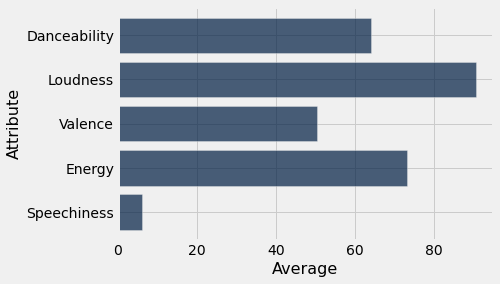

In [158]:
plotting(playlist_2000s)

### Finding data for each year in the 2000s
Now we find the average attribute values for the top 50 songs of each year in the 2000s.

In [149]:
years_stats = []
for i in range(11):
    years_stats.append(get_year_stats(2000 + i, 2000 + i, 50))



### Creating a table of the average attribute value for each year

In [153]:
dance = make_array()
loud = make_array()
valence = make_array()
energy = make_array()
speech = make_array()

for stats in years_stats:
    dance = np.append(dance, stats['danceability'])
    loud = np.append(loud, stats['loudness'])
    valence = np.append(valence, stats['valence'])
    energy = np.append(energy, stats['energy'])
    speech = np.append(speech, stats['speechiness'])


dance = dance * 100
loud = (((loud + 60) * 100) / 60)
valence = valence * 100
energy = energy * 100
speech = speech * 100

yearsTable = Table().with_columns('Year', np.arange(2000, 2011, 1), 'Danceability', dance,
                                  'Loudness', loud, 'Valence', valence, 'Energy', energy,
                                  'Speechiness', speech)
yearsTable

Year,Danceability,Loudness,Valence,Energy,Speechiness
2000,63.428,91.0183,61.21,75.368,9.0702
2001,59.534,89.8702,57.1474,73.1266,6.233
2002,62.356,90.8262,54.428,72.664,7.9482
2003,60.416,91.8639,59.3626,77.42,10.4874
2004,60.924,90.8216,58.5014,75.88,13.6174
2005,62.154,90.4475,51.9744,70.21,11.7876
2006,61.42,91.7147,58.45,76.688,7.3164
2007,60.766,91.1651,56.164,76.724,9.6398
2008,64.396,90.8603,53.6394,71.478,6.7496
2009,63.538,89.7622,53.2904,69.8318,8.7398


### Plotting the change in each attribute value for each year
Plotting the average for each attribute value of the top 50 songs of each year, with a range of 0-100% of the range of possible values.

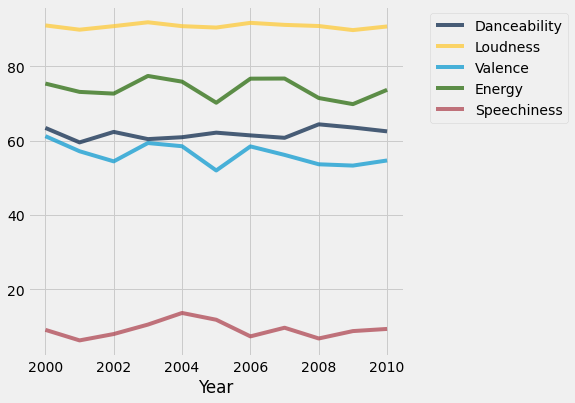

In [151]:
yearsTable.plot('Year')